In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('CBIS-DDSM_combined.csv')
df.head()

,pathology,left or right breast,image view,abnormality type,image_path
0,MALIGNANT,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342386...
1,MALIGNANT,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359308...
2,BENIGN,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.891800...
3,BENIGN,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295360...
4,BENIGN,RIGHT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410524...


In [3]:
# Label Encoding for 'pathology' (MALIGNANT = 1, BENIGN = 0)
label_encoder = LabelEncoder()
df['pathology'] = label_encoder.fit_transform(df['pathology'])
df.head()

,pathology,left or right breast,image view,abnormality type,image_path
0,1,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342386...
1,1,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359308...
2,0,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.891800...
3,0,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295360...
4,0,RIGHT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410524...


In [4]:
# Prepare image paths and labels
image_paths = df['image_path'].values
labels = df['pathology'].values

# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

In [5]:
# ImageDataGenerator for rescaling and validation split
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

# Flowing images from dataframe for training
train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': X_train, 'class': y_train}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),  # EfficientNetB0 requires 224x224 images
    batch_size=32,
    class_mode='raw',
    shuffle=True,
    subset='training'  # for training data
)

# Flowing images from dataframe for validation
validation_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': X_train, 'class': y_train}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False,
    subset='validation'  # for validation data
)

# Test data generator
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': X_test, 'class': y_test}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

Found 1833 validated image filenames.
Found 458 validated image filenames.
Found 573 validated image filenames.


In [6]:
# Load the EfficientNetB0 model, with weights pre-trained on ImageNet, excluding the top fully connected layers
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
efficientnet_base.trainable = False

# Build the model
model = models.Sequential([
    efficientnet_base, 
    layers.GlobalAveragePooling2D(),  
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  
    layers.Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,705,956 (17.95 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
# Train the model 
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.5599 - loss: 0.7587 - val_accuracy: 0.6463 - val_loss: 0.6153
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.6434 - loss: 0.6275 - val_accuracy: 0.6725 - val_loss: 0.5977
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.6748 - loss: 0.5972 - val_accuracy: 0.6616 - val_loss: 0.5971
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.7043 - loss: 0.5596 - val_accuracy: 0.6725 - val_loss: 0.5765
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.7015 - loss: 0.5427 - val_accuracy: 0.6921 - val_loss: 0.5703
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.7206 - loss: 0.5456 - val_accuracy: 0.6790 - val_loss: 0.5817
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.7335 - loss: 0.5304 - val_accuracy: 0.6725 - val_loss: 0.6085
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.7427 - loss: 0.5093 - val_accuracy: 0.6965 - v

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc:.4f}")
model.save('efficientnetb0_model.h5')

18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7152 - loss: 0.6879
Test Accuracy: 0.7347


In [11]:
test_loss

0.6847479939460754

In [9]:
model.save('efficientnetb0_model.h5')

In [9]:
# Load the saved model
from tensorflow.keras.models import load_model
model = load_model('efficientnetb0_model.h5')

18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step


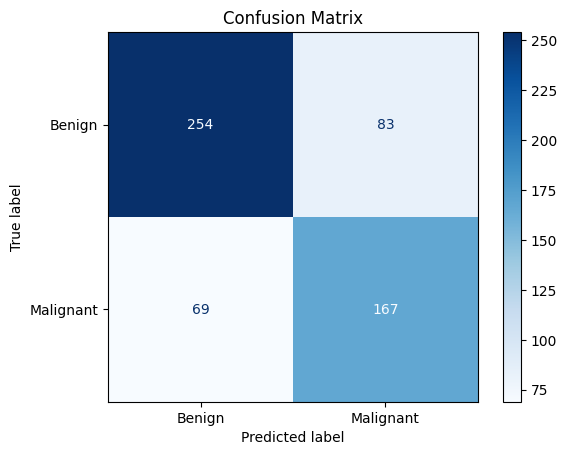

In [10]:
# Import additional necessary libraries
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the true labels from the test generator
y_true = test_generator.labels
# Predict the labels (these will be probabilities)
y_pred_prob = model.predict(test_generator, steps=len(test_generator))

# Convert predicted probabilities to binary labels (threshold at 0.5)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])

# Plot the confusion matrix using matplotlib
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# saved model
breast_cancer_model = tf.keras.models.load_model('efficientnetb0_model.h5')

# Function to preprocess the image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

# Function to make a prediction
def predict_breast_cancer(img_path):
    preprocessed_img = preprocess_image(img_path)
    prediction = breast_cancer_model.predict(preprocessed_img)
    predicted_class = 'Malignant' if prediction[0][0] >= 0.5 else 'Benign'
    confidence_score = prediction[0][0] if predicted_class == 'Malignant' else (1 - prediction[0][0])
    return predicted_class, confidence_score

# Path to the image
img_path = 'CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg'  # Malignant example

# Call the prediction function and print the result
predicted_class, confidence_score = predict_breast_cancer(img_path)
print(f"The model predicts this image as: {predicted_class} with a confidence score of {confidence_score:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
The model predicts this image is: Malignant with a confidence score of 0.7831
